In [12]:
import sys
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import gc
sys.path.append(os.path.join(os.path.split(sys.path[0])[0],"scripts"))
from augmentation import augment
from data_generator import DOTASequence, SegmentationSequence
import data_generator
import model_builder
import train

In [10]:
images_path = '../data/train/images'
annot_path = '../data/train/masks'
seg_generator = SegmentationSequence(images_path, annot_path, augmenter = augment)

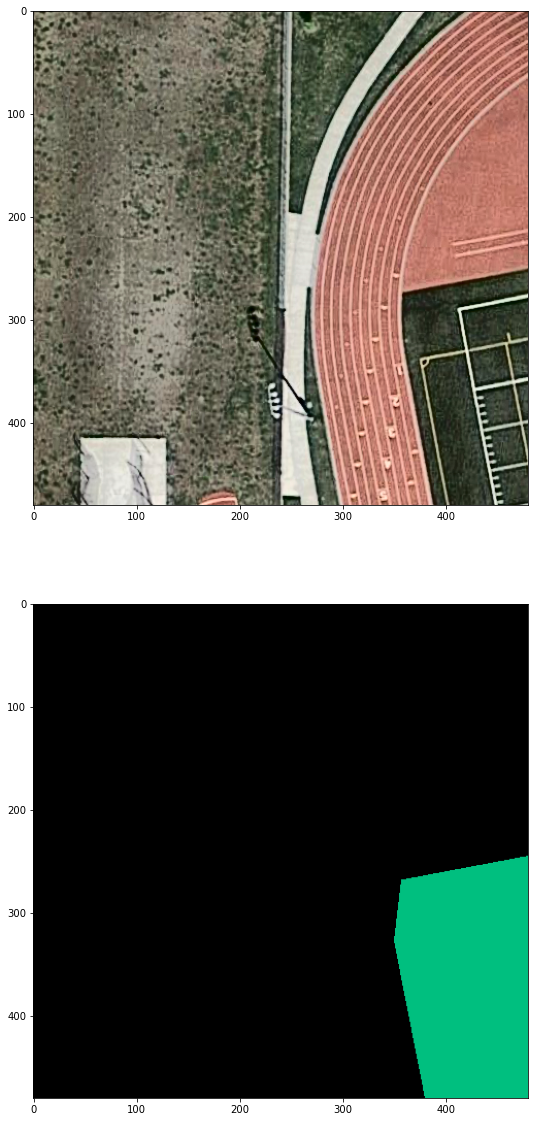

In [20]:
# Visualize data
img, mask = seg_generator[0]
img = img[0].astype(np.uint8)
mask = mask[0]
fig = plt.figure(figsize=(10,20))
fig.add_subplot(2, 1, 1)
plt.imshow(img)
fig.add_subplot(2, 1, 2)
plt.imshow(data_generator.onehot_to_rgb(mask, data_generator.idx_to_rgb))

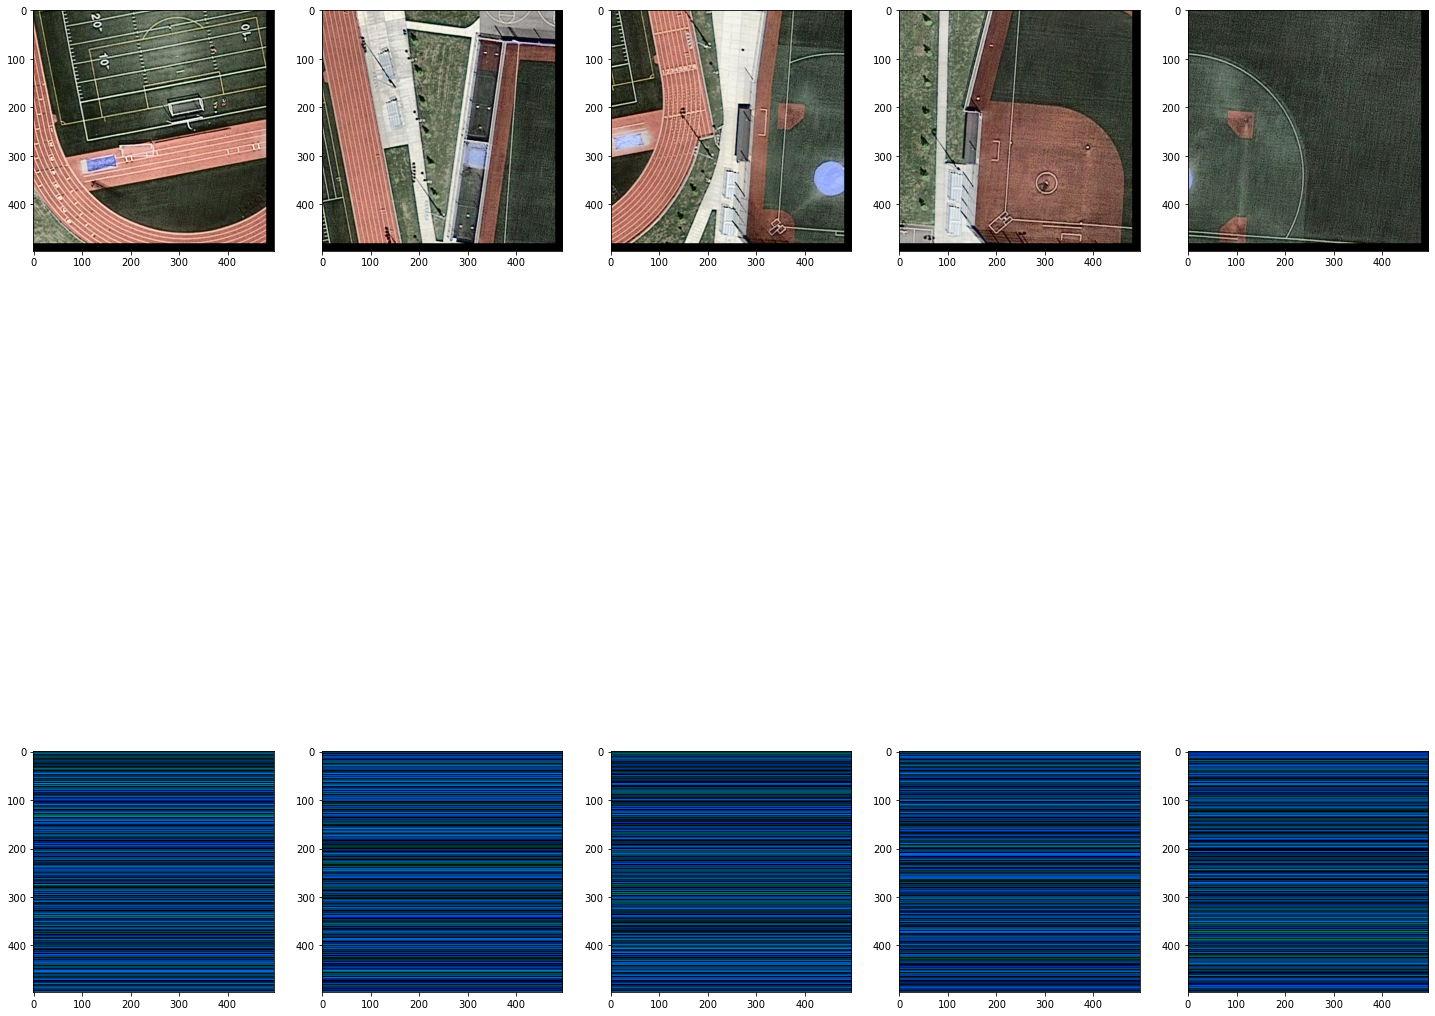

In [21]:
# Visualize untrained model
model = model_builder.build_segmentation_model((None, None, 3), 4, 3, 8, 16)
imgbatch, annotbatch = seg_generator[0]
fig = plt.figure(figsize=(25, 25))
for i, img in enumerate(imgbatch):
    padded_img = np.zeros(
        (1, (img.shape[0] // 16 + 1) * 16, (img.shape[1] // 16 + 1) * 16, 3)
    )
    padded_img[0, : img.shape[0], : img.shape[1], :] = img
    pred = model.predict(padded_img)
    pred = np.argmax(pred, axis=3)[0]
    fig.add_subplot(2, 5, i + 1)
    plt.imshow(padded_img[0].astype(np.uint8))
    fig.add_subplot(2, 5, i + 6)
    plt.imshow(data_generator.onehot_to_rgb(pred, data_generator.idx_to_rgb))

In [ ]:
# Load trained model
tf.keras.backend.clear_session()
del model
gc.collect()
model = tf.keras.models.load_model("../scripts/ckpts", compile=False, custom_objects={'iou_coef': train.iou_coef})

In [ ]:
# Visualize trained model
seg_generator = SegmentationSequence(
        images_path, annot_path, batch_size=1
    )
for i in range(30):
    img, mask = seg_generator[0]

img.shape = (1, 480, 480, 3)
mask.shape = (1, 480, 480, 16)
plt.figure(figsize=(10,10))
plt.imshow(img[0])
pred = model.predict(img)[0]
pred = pred * 255
pred = pred.astype(np.uint8)
fig = plt.figure(figsize=(8,48))
for cnum in range(16):
    fig.add_subplot(16, 2, 2 * cnum + 1)
    plt.imshow(mask[0,:,:,cnum], cmap='hot', interpolation="nearest")
    fig.add_subplot(16, 2, 2 * cnum + 2)
    plt.imshow(pred[:,:,cnum], cmap='hot', interpolation="nearest")

pred_max = np.argmax(pred, axis=2)
fig = plt.figure(figsize=(10,10))
plt.imshow(data_generator.onehot_to_rgb(pred_max, data_generator.idx_to_rgb))

In [ ]:
# Run when finished to clean up
'''
tf.keras.backend.clear_session()
del model
gc.collect()
'''